This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working model. 

The complete evaluation script can be found in the root directory of the repository `eval_direct.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import pickle
import copy
import xarray as xr
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_theme(context='paper')


# Adjusting global plotting parameters
plt.rcParams['font.size'] = 26        # Adjusts the main font size
plt.rcParams['axes.labelsize'] = 26   # Font size of x and y labels
plt.rcParams['xtick.labelsize'] = 26  # Font size of numbers on x-axis
plt.rcParams['ytick.labelsize'] = 26  # Font size of numbers on y-axis
plt.rcParams['legend.fontsize'] = 26  # Font size of legend

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import model, mlp, cnn, ae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 42


## Prediction Visualization

For ClimaX...

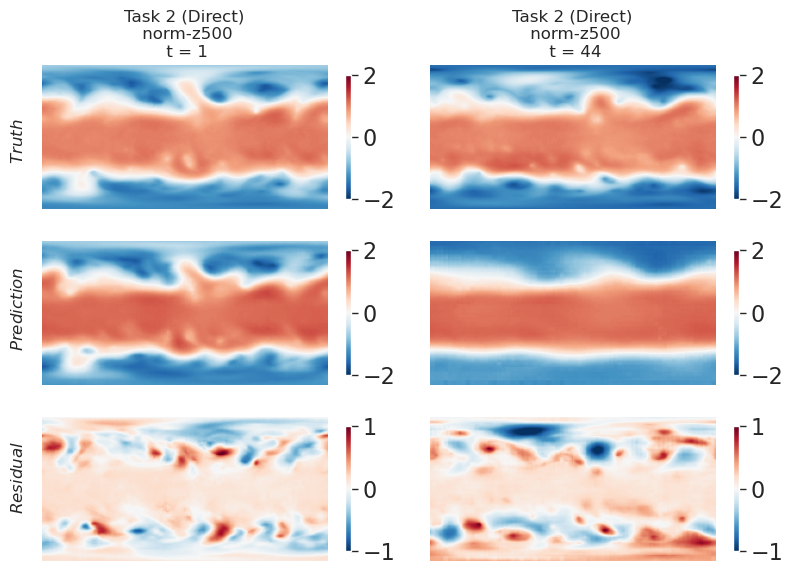

In [49]:
#################### CHANGE THIS ####################
date_idx = 0
param = 'z'
level = 500
model_name = 'climax'
task_num = 2

plot_idx = [1, config.N_STEPS - 1]
######################################################

all_preds = list()
all_truth = list()

## Dataset: Prediction
### List filenames related to the model and task number

log_dir = Path('../logs') / model_name
preds_filepath = log_dir / 'preds' / f'task{task_num}'
preds_files = list(preds_filepath.glob('*.pkl'))
preds_files.sort()

### Load the actual predictions (only for t = 1, and t = 44)
for file_path in np.array(preds_files)[[0, -1]]:
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        data = data['pred'][f'{param}_{level}']
        all_preds.append(data[date_idx])

## Dataset: Label
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
_, output_x, output_y = output_dataset[date_idx]

for idx in plot_idx:
    all_truth.append(output_y[idx][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())


# Plotting
all_truth = np.array(all_truth)
all_preds = np.array(all_preds)
all_preds = (all_preds - all_preds.mean()) / all_preds.std()

f, ax = plt.subplots(3, len(plot_idx), figsize=(8, 3 * len(plot_idx)))

for time_idx in range(len(plot_idx)):

    im0 = ax[0, time_idx].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    # ax[0, time_idx].set_title(f'Truth\n(step={plot_idx[time_idx]})')
    ax[0, time_idx].axis('off')
    cbar0 = f.colorbar(im0, ax=ax[0, time_idx], shrink=0.8)

    im1 = ax[1, time_idx].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    # ax[1, time_idx].set_title(f'Prediction\n(step={plot_idx[time_idx]})')
    ax[1, time_idx].axis('off')
    cbar1 = f.colorbar(im1, ax=ax[1, time_idx], shrink=0.8)

    im2 = ax[2, time_idx].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
    # ax[2, time_idx].set_title(f'Residual\n(step={plot_idx[time_idx]})')
    ax[2, time_idx].axis('off')
    cbar2 = f.colorbar(im2, ax=ax[2, time_idx], shrink=0.8)

# Adding titles for each row
titles = [r'$Truth$', r'$Prediction$', r'$Residual$']
for idx, title in enumerate(titles):
    f.text(-0.01, 0.75 - idx*0.28, title, va='center', ha='left', fontsize=12, rotation=90)

ax[0,0].set_title(f'Task {task_num} (Direct)\n norm-{param}{level}\n t = 1', fontsize=12)
ax[0,1].set_title(f'Task {task_num} (Direct)\n norm-{param}{level}\n t = 44', fontsize=12)
plt.tight_layout()
plt.show()
f.savefig(f'../docs/preds_{model_name}_{param}{level}_direct_Task {task_num}.pdf', dpi=200, bbox_inches='tight');


For UNet...

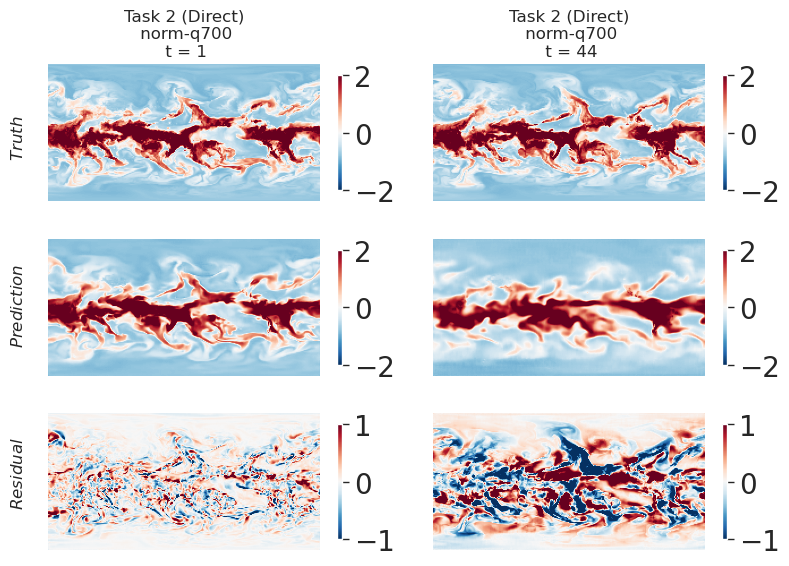

In [19]:
#################### CHANGE THIS ####################
date_idx = 0
param = 'q'
level = 700
model_name = 'unet_s2s'
task_num = 2

DELTA_T = np.array([1, 44])
######################################################

## Dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)


## Load config filepath which consists of all the definition needed to fit/eval a model
log_dir = Path('../logs') / model_name
model_config_filepath = Path(f'../chaosbench/configs/{model_name}.yaml')

with open(model_config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

## Checkpointing
version_nums = [0, 22] if task_num == 1 else [2, 23]
assert len(version_nums) == len(DELTA_T)

baselines = list()
for version_num in version_nums:
    ckpt_filepath = log_dir / f'lightning_logs/version_{version_num}/checkpoints/'
    ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
    baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
    baseline = baseline.load_from_checkpoint(ckpt_filepath)
    baselines.append(copy.deepcopy(baseline))


all_preds = list()
all_truth = list()

with torch.no_grad():

    timestamp, input_x, input_y = input_dataset[date_idx]
    _, output_x, output_y = output_dataset[date_idx]

    curr_x = input_x.unsqueeze(0).to(device)

    for step_idx, delta in enumerate(DELTA_T):
        preds = baselines[step_idx](curr_x)
        curr_y = output_y.unsqueeze(0)[:, step_idx]
        all_preds.append(preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
        all_truth.append(curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())


# Plotting
all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

f, ax = plt.subplots(3, len(DELTA_T), figsize=(8, 3 * len(DELTA_T)))

for time_idx in range(len(DELTA_T)):

    im0 = ax[0, time_idx].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    # ax[0, time_idx].set_title(f'Truth\n(step={plot_idx[time_idx]})')
    ax[0, time_idx].axis('off')
    cbar0 = f.colorbar(im0, ax=ax[0, time_idx], shrink=0.8)

    im1 = ax[1, time_idx].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    # ax[1, time_idx].set_title(f'Prediction\n(step={plot_idx[time_idx]})')
    ax[1, time_idx].axis('off')
    cbar1 = f.colorbar(im1, ax=ax[1, time_idx], shrink=0.8)

    im2 = ax[2, time_idx].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
    # ax[2, time_idx].set_title(f'Residual\n(step={plot_idx[time_idx]})')
    ax[2, time_idx].axis('off')
    cbar2 = f.colorbar(im2, ax=ax[2, time_idx], shrink=0.8)

# Adding titles for each row
titles = [r'$Truth$', r'$Prediction$', r'$Residual$']
for idx, title in enumerate(titles):
    f.text(-0.01, 0.75 - idx*0.28, title, va='center', ha='left', fontsize=12, rotation=90)

ax[0,0].set_title(f'Task {task_num} (Direct)\n norm-{param}{level}\n t = 1', fontsize=12)
ax[0,1].set_title(f'Task {task_num} (Direct)\n norm-{param}{level}\n t = 44', fontsize=12)
plt.tight_layout()
plt.show()
f.savefig(f'../docs/preds_{model_name}_{param}{level}_direct_Task {task_num}.pdf', dpi=200, bbox_inches='tight');


## Power Spectrum

### Autoregressive approach - SoTA

For Panguweather...

Processing panguweather: t-850
Processing panguweather: z-500
Processing panguweather: q-700


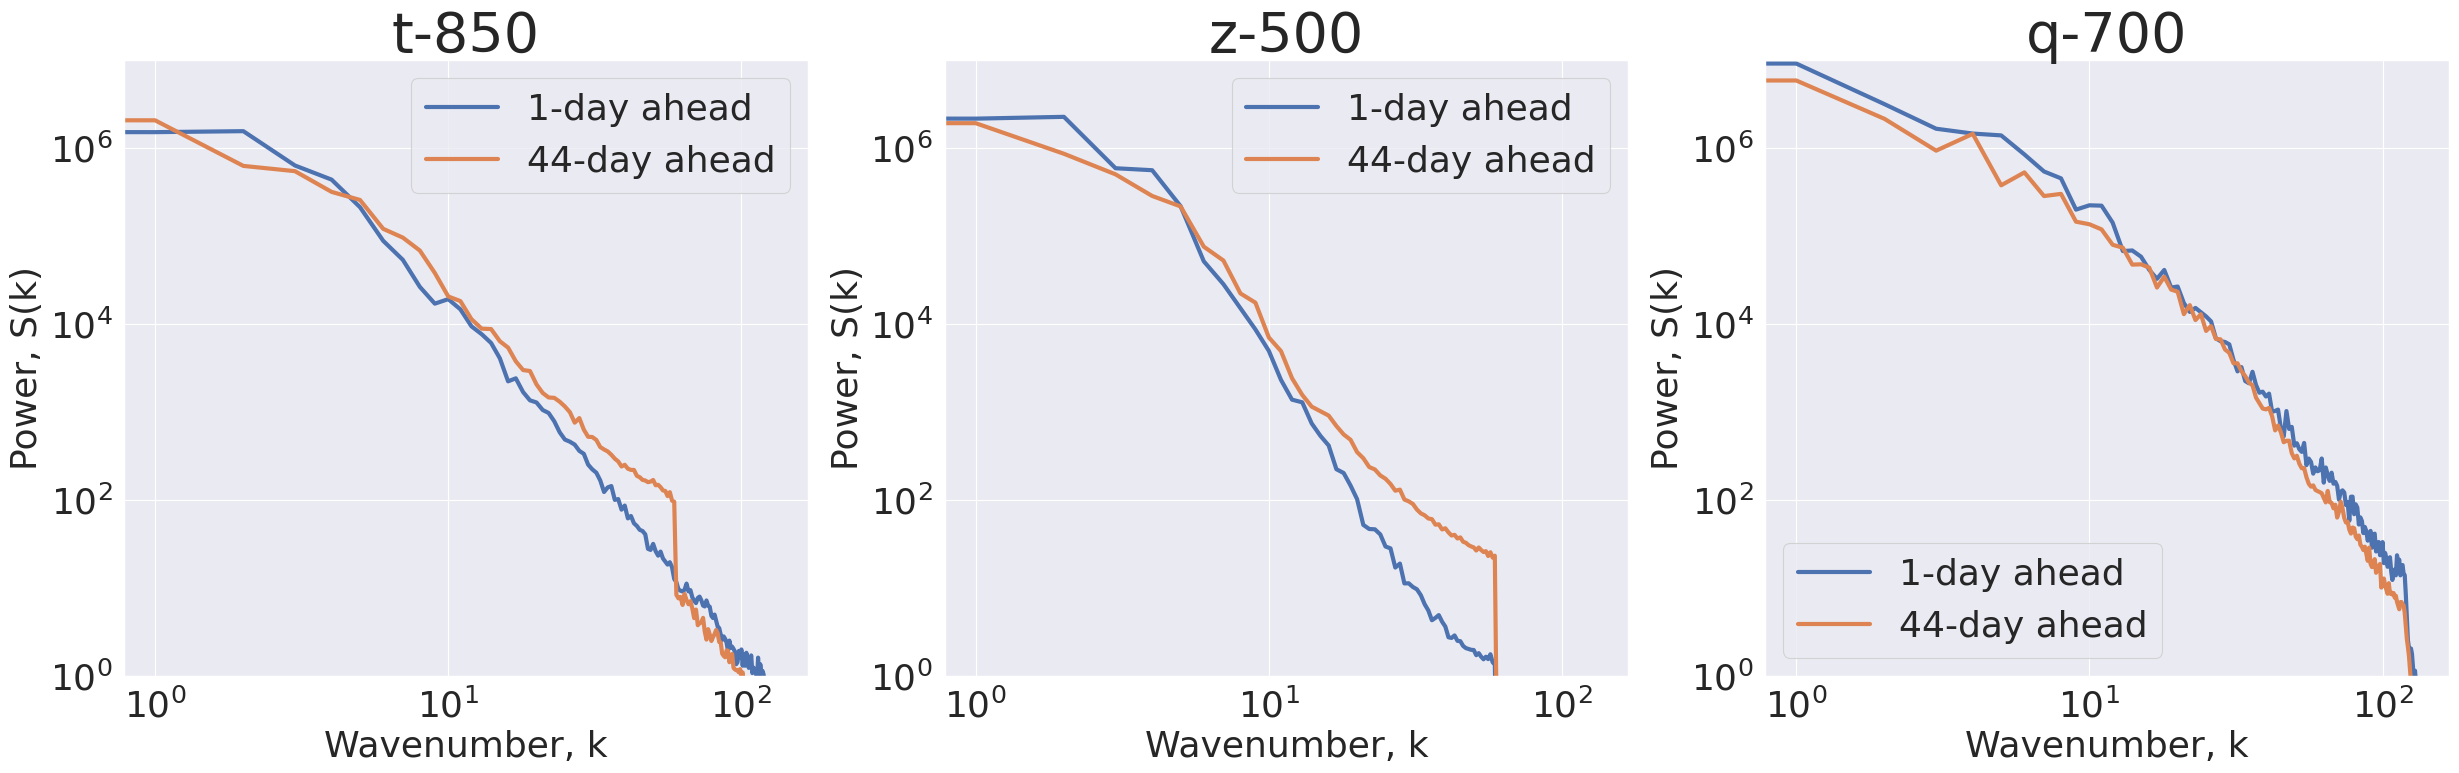

In [37]:
#################### CHANGE THIS ####################
model_name = 'panguweather'
date_idx = 0
n_steps = [0, 43]
param_levels = [['t', 850], ['z', 500], ['q', 700]]
######################################################

all_Sk = dict()
f, ax = plt.subplots(1, len(param_levels), figsize=(10*len(param_levels), 8))

## Preprocessing
log_dir = Path('../logs') / model_name
preds_dataset = xr.open_dataset(
    log_dir / f'{model_name}.grib', 
    backend_kwargs={'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'}}
)

preds_dataset = preds_dataset.coarsen(step=4, latitude=6, longitude=6, boundary='trim').mean()
preds_dataset['z'] = preds_dataset['z'] / 9.8 # to gpm conversion
preds_dataset = preds_dataset.interp(latitude=np.linspace( 
                                        preds_dataset.latitude.values.max(),
                                        preds_dataset.latitude.values.min(), 121))

for param_level_idx, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]

    print(f'Processing {model_name}: {param}-{level}')

    ## Dataset: Preds
    all_preds = preds_dataset[param].sel(isobaricInhPa=int(level)).values
    all_preds = (all_preds - all_preds.mean()) / all_preds.std()
    
    ## Dataset: Label
    output_dataset = dataset.S2SObsDataset(years=[2016], n_step=config.N_STEPS-1)
    _, _, output_y = output_dataset[0]
    all_truth = output_y[:, config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy()

    # Compute power spectrum
    curr_pred_Sk, curr_truth_Sk = list(), list()

    for step_idx in range(all_truth.shape[0]):
        pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
        pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
        pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

        ny, nx = pred_t.shape
        kx = np.fft.fftfreq(nx) * nx
        ky = np.fft.fftfreq(ny) * ny

        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)

        k_bins = np.arange(0.5, np.max(k), 1)
        k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        pred_Sk = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
        truth_Sk = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

        curr_pred_Sk.append(pred_Sk)
        curr_truth_Sk.append(truth_Sk)
        
        # Plot power spectrum
        if step_idx in n_steps:
            step_num = n_steps.index(step_idx)
            ax[param_level_idx].set_title(f'{param}-{level}', fontsize=40)
            ax[param_level_idx].loglog(pred_Sk, label=f'{step_idx + 1}-day ahead', linewidth=3)
            ax[param_level_idx].set_xlabel('Wavenumber, k')
            ax[param_level_idx].set_ylabel(f'Power, S(k)')
            ax[param_level_idx].set_ylim([10**0, 10**7])
            ax[param_level_idx].legend()

    all_Sk[f'{param}-{level}'] = np.array(curr_pred_Sk)
    all_Sk['truth'] = np.array(curr_truth_Sk)
                
plt.show()
f.savefig(f'../docs/specdiv_{model_name}_sota.pdf', dpi=200, bbox_inches='tight');

For Fourcastnetv2

Processing fourcastnetv2: t-850
Processing fourcastnetv2: z-500


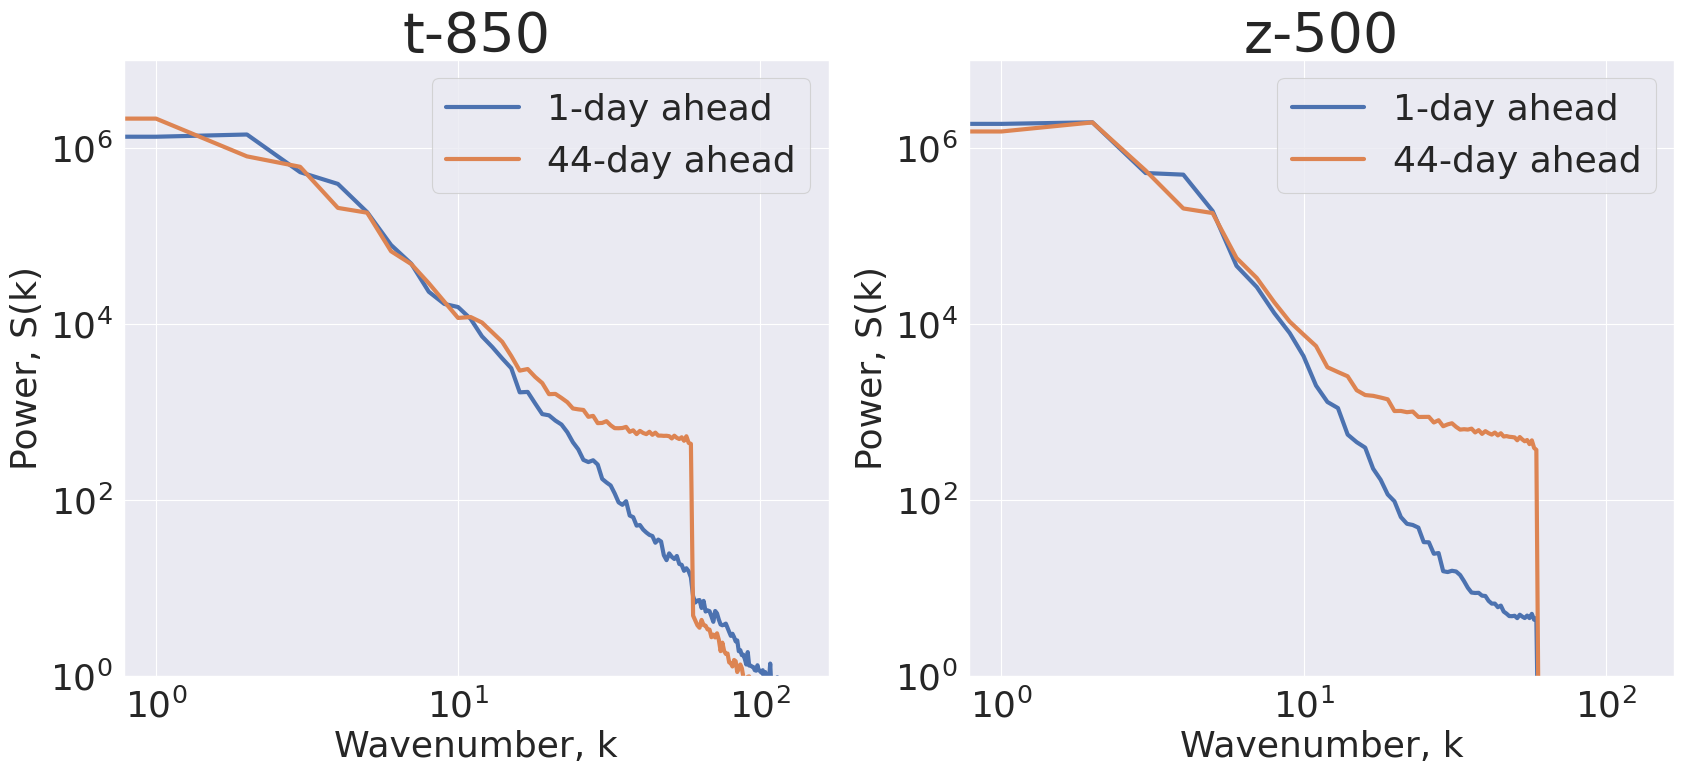

In [51]:
#################### CHANGE THIS ####################
model_name = 'fourcastnetv2'
date_idx = 0
n_steps = [0, 43]
param_levels = [['t', 850], ['z', 500]]
######################################################

all_Sk = dict()
f, ax = plt.subplots(1, len(param_levels), figsize=(10*len(param_levels), 8))

## Preprocessing
log_dir = Path('../logs') / model_name
preds_dataset = xr.open_dataset(
    log_dir / f'{model_name}-small.grib', 
    backend_kwargs={'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'}}
)

preds_dataset = preds_dataset.coarsen(step=4, latitude=6, longitude=6, boundary='trim').mean()
preds_dataset['z'] = preds_dataset['z'] / 9.8 # to gpm conversion
preds_dataset = preds_dataset.interp(latitude=np.linspace( 
                                        preds_dataset.latitude.values.max(),
                                        preds_dataset.latitude.values.min(), 121))

for param_level_idx, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]

    print(f'Processing {model_name}: {param}-{level}')

    ## Dataset: Preds
    all_preds = preds_dataset[param].sel(isobaricInhPa=int(level)).values
    all_preds = (all_preds - all_preds.mean()) / all_preds.std()
    
    ## Dataset: Label
    output_dataset = dataset.S2SObsDataset(years=[2016], n_step=config.N_STEPS-1)
    _, _, output_y = output_dataset[0]
    all_truth = output_y[:, config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy()

    # Compute power spectrum
    curr_pred_Sk, curr_truth_Sk = list(), list()

    for step_idx in range(all_truth.shape[0]):
        pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
        pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
        pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

        ny, nx = pred_t.shape
        kx = np.fft.fftfreq(nx) * nx
        ky = np.fft.fftfreq(ny) * ny

        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)

        k_bins = np.arange(0.5, np.max(k), 1)
        k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        pred_Sk = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
        truth_Sk = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

        curr_pred_Sk.append(pred_Sk)
        curr_truth_Sk.append(truth_Sk)
        
        # Plot power spectrum
        if step_idx in n_steps:
            step_num = n_steps.index(step_idx)
            ax[param_level_idx].set_title(f'{param}-{level}', fontsize=40)
            ax[param_level_idx].loglog(pred_Sk, label=f'{step_idx + 1}-day ahead', linewidth=3)
            ax[param_level_idx].set_xlabel('Wavenumber, k')
            ax[param_level_idx].set_ylabel(f'Power, S(k)')
            ax[param_level_idx].set_ylim([10**0, 10**7])
            ax[param_level_idx].legend()

    all_Sk[f'{param}-{level}'] = np.array(curr_pred_Sk)
    all_Sk['truth'] = np.array(curr_truth_Sk)
                
plt.show()
f.savefig(f'../docs/specdiv_{model_name}_sota.pdf', dpi=200, bbox_inches='tight');

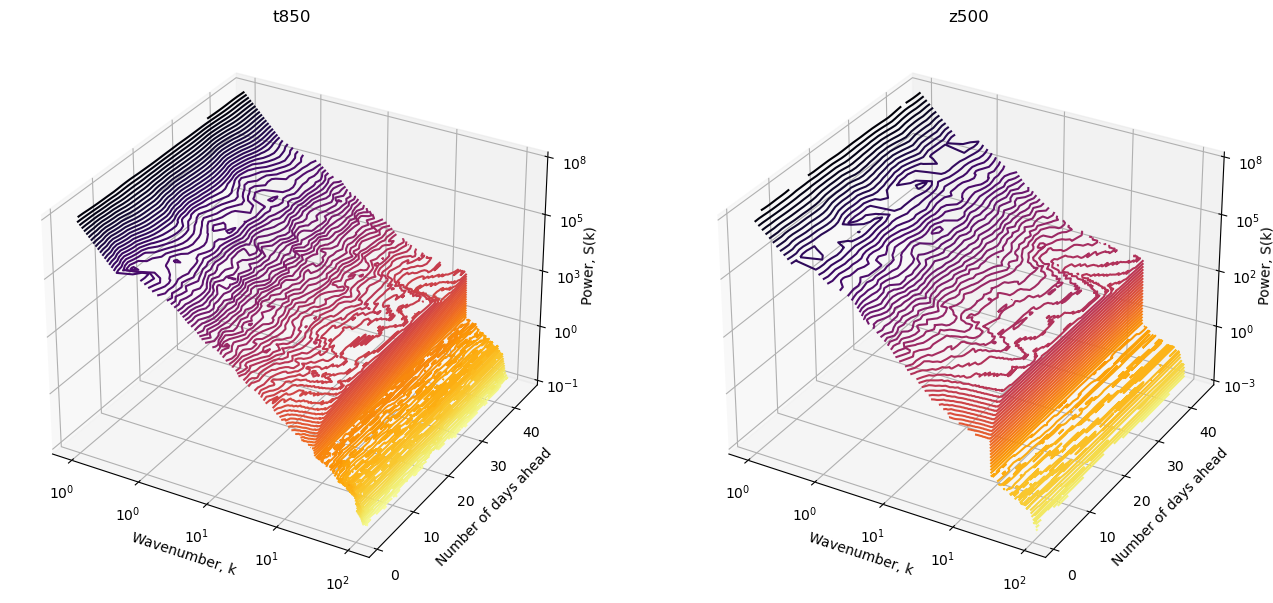

In [46]:
# Plot full power spectra
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def set_log_ticks_10_power(axis, num_ticks=5):
    lims = axis.get_data_interval()
    
    ticks = np.linspace(lims[0], lims[1], num=num_ticks)
    axis.set_ticks(ticks)
    axis.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in ticks])


eps = 1e-50 # to void log(0)
f = plt.figure(figsize=(16, 10))
subplot_idx = 1
    
for param_id, param_level in enumerate(param_levels):

    curr_Sk = all_Sk[f'{param_level[0]}-{param_level[1]}']

    # Plot the 3D contour plot
    ax = f.add_subplot(1, len(param_levels), subplot_idx, projection='3d')
    Wavenumber, Timestep = np.meshgrid(np.arange(1, curr_Sk.shape[1] + 1), np.arange(1, curr_Sk.shape[0] + 1))
    contour = ax.contour3D(np.log10(Wavenumber + eps), Timestep, np.log10(curr_Sk + eps), 100, cmap='inferno_r')

    ax.set_xlabel('Wavenumber, k')
    ax.set_ylabel('Number of days ahead')
    ax.set_zlabel(r'Power, S(k)', labelpad=0.1)

    set_log_ticks_10_power(ax.xaxis)
    set_log_ticks_10_power(ax.zaxis)

    ax.set_title(f'{param_level[0]}{param_level[1]}', fontsize=12)
    subplot_idx += 1

plt.show()
f.savefig(f'../docs/3d_{model_name}_sota.pdf', dpi=200, bbox_inches='tight');

### Direct approach 

For ClimaX...

Processing Task_1/Direct
Processing Task_1/Direct
Processing Task_1/Direct


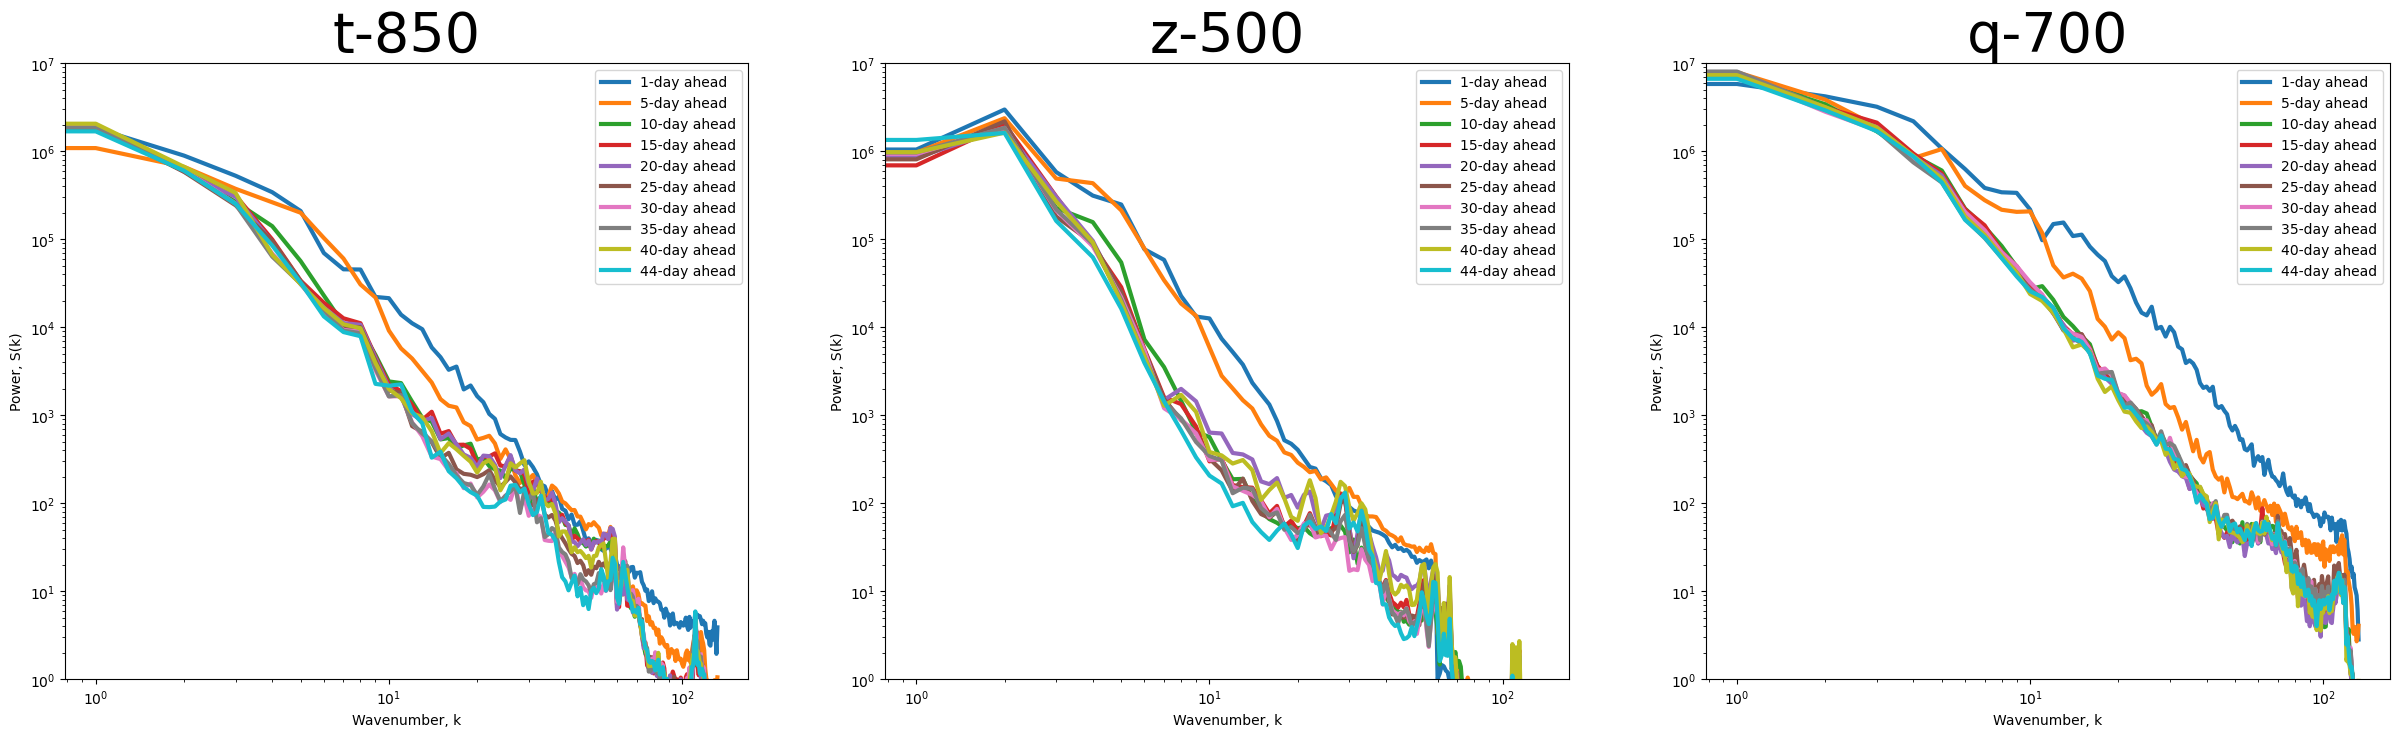

In [18]:
#################### CHANGE THIS ####################
date_idx = 0
delta_t = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 44])
n_steps = np.arange(len(delta_t))
model_name = 'climax'
task_num = 1
model_spec = f'Task_{task_num}/Direct'
######################################################

param_levels = [['t', 850], ['z', 500], ['q', 700]]
all_Sk = dict()

## Initialize dataset
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

## For plotting
f, ax = plt.subplots(1, len(param_levels), figsize=(10*len(param_levels), 8))

for param_level_idx, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]

    print(f'Processing {model_spec}')

    all_preds = list()
    all_truth = list()

    ## Dataset: Prediction
    ### List filenames related to the model and task number

    log_dir = Path('../logs') / model_name
    preds_filepath = log_dir / 'preds' / f'task{task_num}'
    preds_files = list(preds_filepath.glob('*.pkl'))
    preds_files.sort()

    ### Load the actual predictions (only for t = 1, and t = 44)
    for file_path in np.array(preds_files)[n_steps]:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            data = data['pred'][f'{param}_{level}']
            all_preds.append(data[date_idx])

    ## Dataset: Label
    output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
    _, output_x, output_y = output_dataset[date_idx]

    for step_idx in n_steps:
        all_truth.append(output_y[step_idx][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())

    ## Post-process truth and predictions (have to normalize this since it comes in real values)
    all_truth = np.array(all_truth)
    all_preds = np.array(all_preds)
    all_preds = (all_preds - all_preds.mean()) / all_preds.std()

    # Compute power spectrum
    curr_pred_Sk, curr_truth_Sk = list(), list()

    for step_idx in range(all_preds.shape[0]):
        pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
        pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
        pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

        ny, nx = pred_t.shape
        kx = np.fft.fftfreq(nx) * nx
        ky = np.fft.fftfreq(ny) * ny

        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)

        k_bins = np.arange(0.5, np.max(k), 1)
        k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        pred_Sk = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
        truth_Sk = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

        curr_pred_Sk.append(pred_Sk)
        curr_truth_Sk.append(truth_Sk)
        
        # Plot power spectrum
        ax[param_level_idx].set_title(f'{param}-{level}', fontsize=40)
        ax[param_level_idx].loglog(pred_Sk, label=f'{delta_t[step_idx]}-day ahead', linewidth=3)
        ax[param_level_idx].set_xlabel('Wavenumber, k')
        ax[param_level_idx].set_ylabel(f'Power, S(k)')
        ax[param_level_idx].set_ylim([10**0, 10**7])
        ax[param_level_idx].legend()

    all_Sk[f'{model_spec}:{param}-{level}'] = np.array(curr_pred_Sk)
    all_Sk['truth'] = np.array(curr_truth_Sk)
                
plt.show()
# f.savefig(f'../docs/specdiv_{model_name}_direct_Task {task_num}.pdf', dpi=200, bbox_inches='tight');

For UNet...

Processing Task_1/Direct
Processing Task_1/Direct
Processing Task_1/Direct


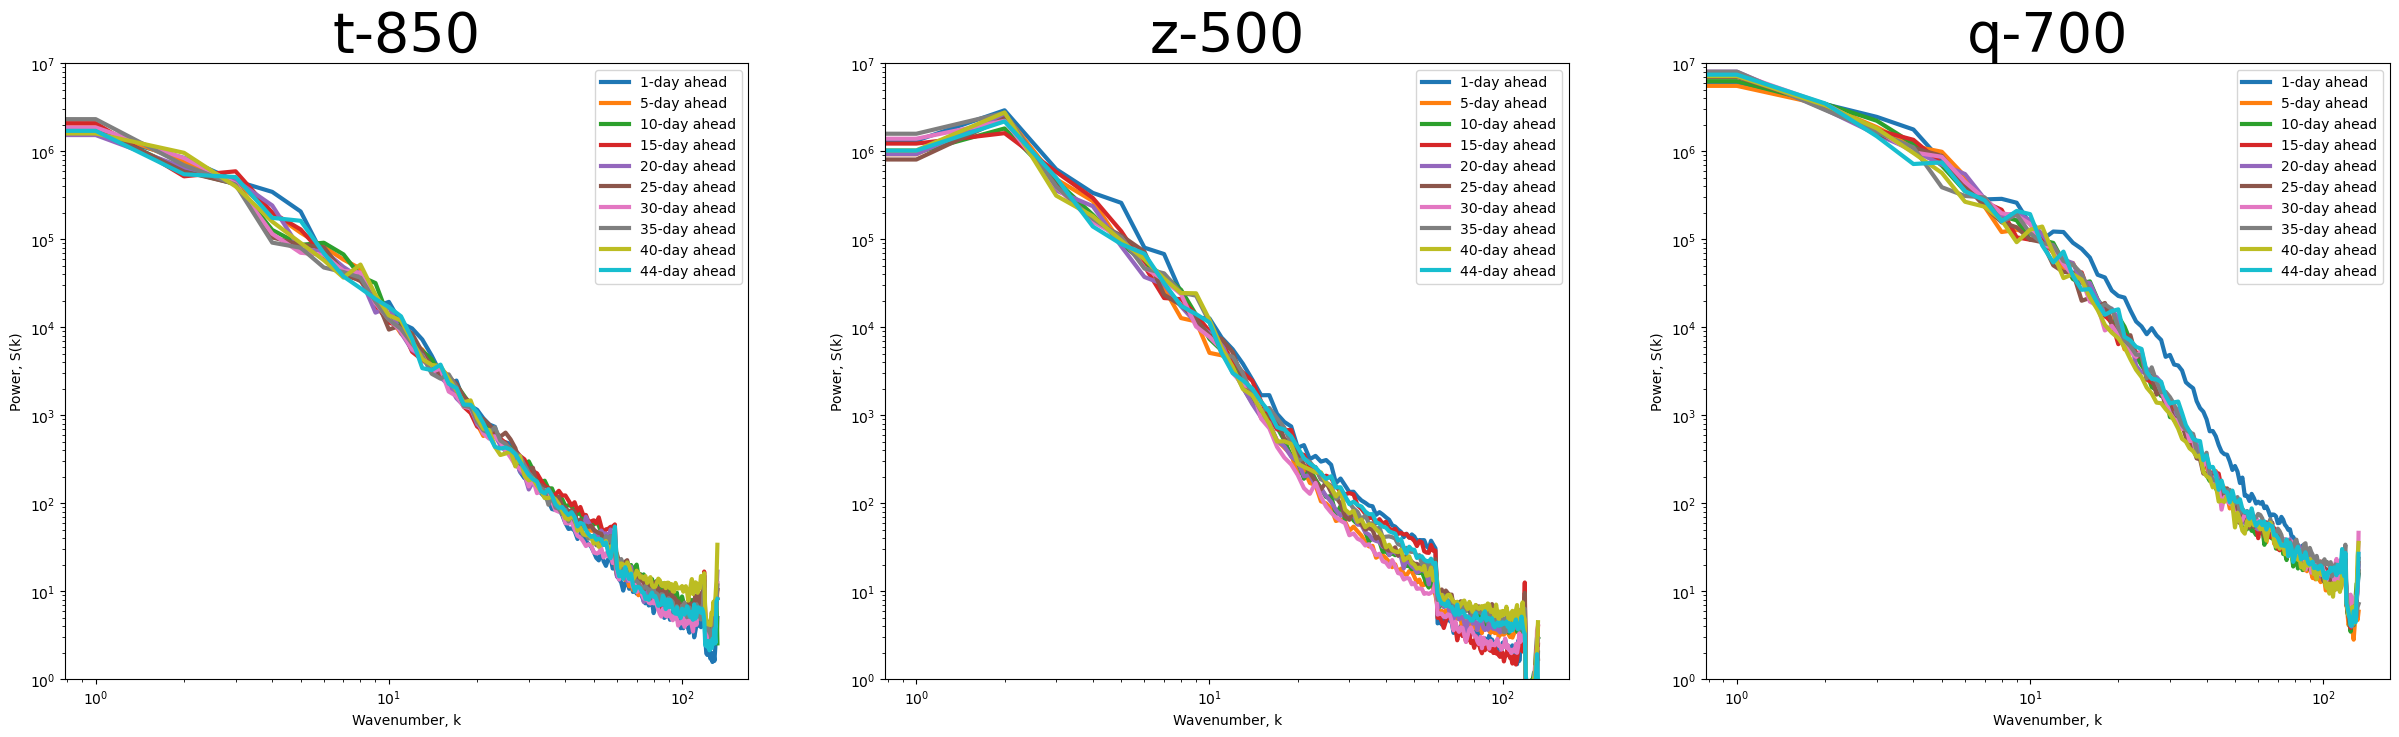

In [24]:
#################### CHANGE THIS ####################
date_idx = 0
delta_t = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 44])
n_steps = np.arange(len(delta_t))
model_name = 'unet_s2s'
task_num = 1
model_spec = f'Task_{task_num}/Direct'
######################################################

param_levels = [['t', 850], ['z', 500], ['q', 700]]
all_Sk = dict()

## Initialize dataset
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

## For plotting
f, ax = plt.subplots(1, len(param_levels), figsize=(10*len(param_levels), 8))

for param_level_idx, param_level in enumerate(param_levels):
    param = param_level[0]
    level = param_level[1]

    print(f'Processing {model_spec}')

    all_preds = list()
    all_truth = list()

    ## Dataset
    input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
    output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

    ## Load config filepath which consists of all the definition needed to fit/eval a model
    log_dir = Path('../logs') / model_name
    model_config_filepath = Path(f'../chaosbench/configs/{model_name}.yaml')

    with open(model_config_filepath, 'r') as config_filepath:
        hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

    model_args = hyperparams['model_args']
    data_args = hyperparams['data_args']

    ## Checkpointing
    version_nums = [0,4,5,6,7,8,9,10,11,12] if task_num == 1 else [2,13,14,15,16,17,18,19,20,21]
    assert len(version_nums) == len(delta_t)

    baselines = list()
    for version_num in version_nums:
        ckpt_filepath = log_dir / f'lightning_logs/version_{version_num}/checkpoints/'
        ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
        baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
        baseline = baseline.load_from_checkpoint(ckpt_filepath)
        baselines.append(copy.deepcopy(baseline))


    all_preds = list()
    all_truth = list()

    with torch.no_grad():

        timestamp, input_x, input_y = input_dataset[date_idx]
        _, output_x, output_y = output_dataset[date_idx]

        curr_x = input_x.unsqueeze(0).to(device)

        for step_idx, delta in enumerate(delta_t):
            preds = baselines[step_idx](curr_x)
            curr_y = output_y.unsqueeze(0)[:, step_idx]
            all_preds.append(preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
            all_truth.append(curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())

    all_preds = np.array(all_preds)
    all_truth = np.array(all_truth)
    all_preds = (all_preds - all_preds.mean()) / all_preds.std()

    # Compute power spectrum
    curr_pred_Sk, curr_truth_Sk = list(), list()

    for step_idx in range(all_preds.shape[0]):
        pred_t, truth_t = all_preds[step_idx], all_truth[step_idx]
        pred_power_t, truth_power_t = np.fft.fft2(pred_t), np.fft.fft2(truth_t)
        pred_power_t, truth_power_t = np.abs(pred_power_t)**2, np.abs(truth_power_t)**2

        ny, nx = pred_t.shape
        kx = np.fft.fftfreq(nx) * nx
        ky = np.fft.fftfreq(ny) * ny

        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)

        k_bins = np.arange(0.5, np.max(k), 1)
        k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        pred_Sk = np.histogram(k, bins=k_bins, weights=pred_power_t)[0] / np.histogram(k, bins=k_bins)[0]
        truth_Sk = np.histogram(k, bins=k_bins, weights=truth_power_t)[0] / np.histogram(k, bins=k_bins)[0]

        curr_pred_Sk.append(pred_Sk)
        curr_truth_Sk.append(truth_Sk)
        
        # Plot power spectrum
        ax[param_level_idx].set_title(f'{param}-{level}', fontsize=40)
        ax[param_level_idx].loglog(pred_Sk, label=f'{delta_t[step_idx]}-day ahead', linewidth=3)
        ax[param_level_idx].set_xlabel('Wavenumber, k')
        ax[param_level_idx].set_ylabel(f'Power, S(k)')
        ax[param_level_idx].set_ylim([10**0, 10**7])
        ax[param_level_idx].legend()

    all_Sk[f'{model_spec}:{param}-{level}'] = np.array(curr_pred_Sk)
    all_Sk['truth'] = np.array(curr_truth_Sk)
                
plt.show()
# f.savefig(f'../docs/specdiv_{model_name}_direct_Task {task_num}.pdf', dpi=200, bbox_inches='tight');

In [ ]:
# Plot full power spectra
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def set_log_ticks_10_power(axis, num_ticks=5):
    lims = axis.get_data_interval()
    
    ticks = np.linspace(lims[0], lims[1], num=num_ticks)
    axis.set_ticks(ticks)
    axis.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in ticks])


eps = 1e-50 # to void log(0)
f = plt.figure(figsize=(16, 10))
subplot_idx = 1
    
for param_id, param_level in enumerate(param_levels):

    curr_Sk = all_Sk[f'{model_spec}:{param_level[0]}-{param_level[1]}']

    # Plot the 3D contour plot
    ax = f.add_subplot(1, len(param_levels), subplot_idx, projection='3d')
    Wavenumber, Timestep = np.meshgrid(np.arange(1, curr_Sk.shape[1] + 1), delta_t)
    contour = ax.contour3D(np.log10(Wavenumber + eps), Timestep, np.log10(curr_Sk + eps), 100, cmap='inferno_r')

    ax.set_xlabel('Wavenumber, k')
    ax.set_ylabel('Number of days ahead')
    ax.set_zlabel(r'Power, S(k)', labelpad=0.1)

    set_log_ticks_10_power(ax.xaxis)
    set_log_ticks_10_power(ax.zaxis)

    ax.set_title(f'{model_spec}\n {param_level[0]}{param_level[1]}', fontsize=12)
    subplot_idx += 1

plt.show()
# f.savefig(f'../docs/3d_{model_name}_sota.pdf', dpi=200, bbox_inches='tight');